# Fast Food Marketing Campaign A/B Testing

**Scenario**

A fast-food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greatest effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks.

**Goal**

Evaluate A/B testing results and decide which marketing strategy works the best.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
from statsmodels.stats.multicomp import MultiComparison
from scipy.stats import shapiro, levene, kruskal, f_oneway

In [2]:
df = pd.read_csv('../input/fast-food-marketing-campaign-ab-test/WA_Marketing-Campaign.csv')
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MarketID,548.0,5.715328,2.877001,1.00,3.000,6.0,8.0000,10.00
LocationID,548.0,479.656934,287.973679,1.00,216.000,504.0,708.0000,920.00
AgeOfStore,548.0,8.503650,6.638345,1.00,4.000,7.0,12.0000,28.00
Promotion,548.0,2.029197,0.810729,1.00,1.000,2.0,3.0000,3.00
week,548.0,2.500000,1.119055,1.00,1.750,2.5,3.2500,4.00
SalesInThousands,548.0,53.466204,16.755216,17.34,42.545,50.2,60.4775,99.65


<Axes: >

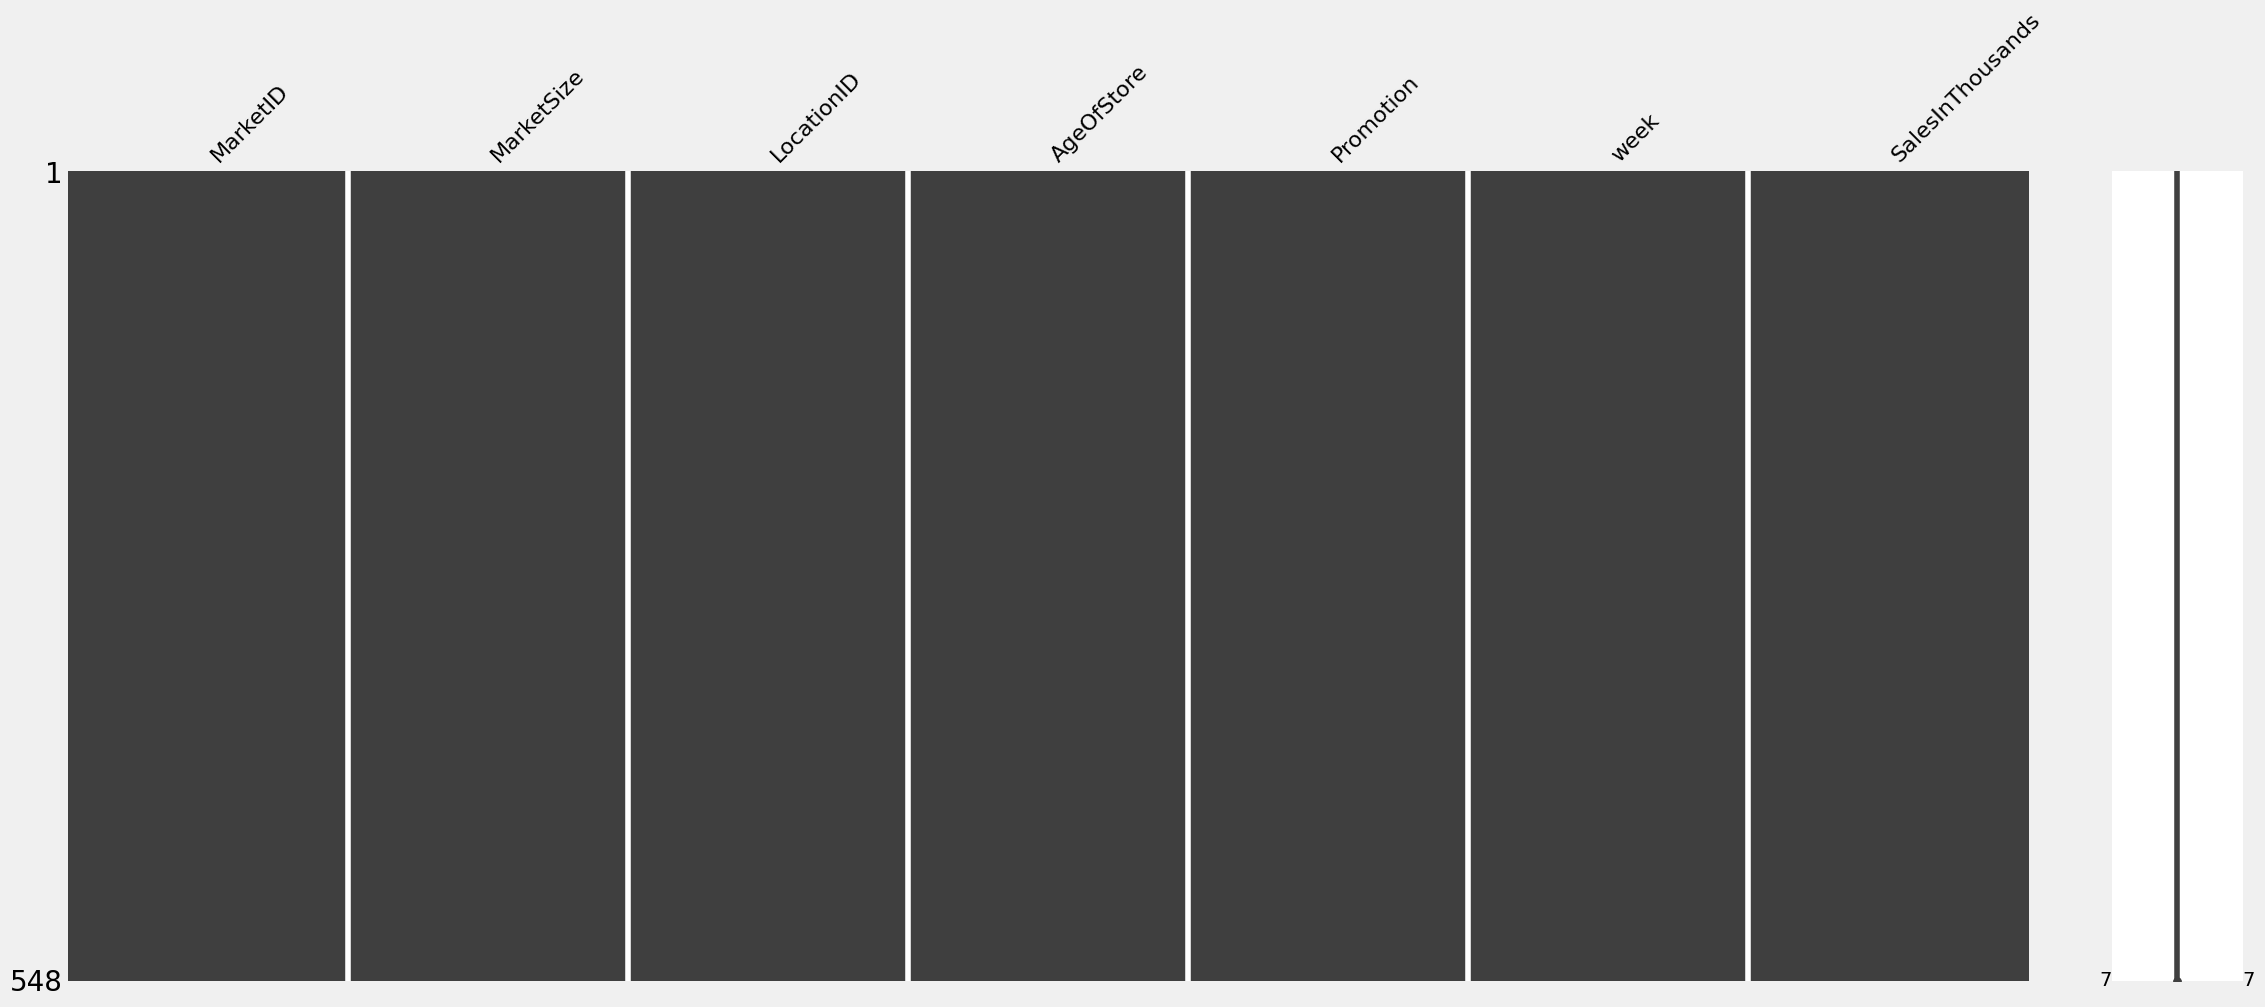

In [5]:
msno.matrix(df)

No missing values found in the dataset.

In [6]:
df.groupby('Promotion').agg({'SalesInThousands': ['count', 'mean', 'median', 'sum']})

SalesInThousands                             
                     count       mean  median       sum
Promotion                                              
1                      172  58.099012  55.385   9993.03
2                      188  47.329415  45.385   8897.93
3                      188  55.364468  51.165  10408.52

The table above shows the sales descriptive statistics based on each promotion types. Promotion 1 seems to obtain more revenue for the fast food chain, given the highest average and median value of sales. Then followed by promotion 3 and 2. But, are the evidences enough? We will find out more using hypothesis testing.

# Analysis of Variance (ANOVA)

ANOVA is a statistical test that is used to determine if there is a significant difference between the means of three or more groups. ANOVA examines the variance within the groups and variance between the groups. The statistic calculated in an ANOVA test is the F-statistic. In this case, we would like to check whether promotion affects the sales or not, so a single way ANOVA can be performed.

There are several assumptions that must be fulfilled when doing an ANOVA test.
1. The variables should be close to normal distribution.
2. The variance of population that the samples come from are equal.

### Check for Normality

In [7]:
promotion_1_sales = np.array(df[df['Promotion'] == 1]['SalesInThousands'])
promotion_2_sales = np.array(df[df['Promotion'] == 2]['SalesInThousands'])
promotion_3_sales = np.array(df[df['Promotion'] == 3]['SalesInThousands'])

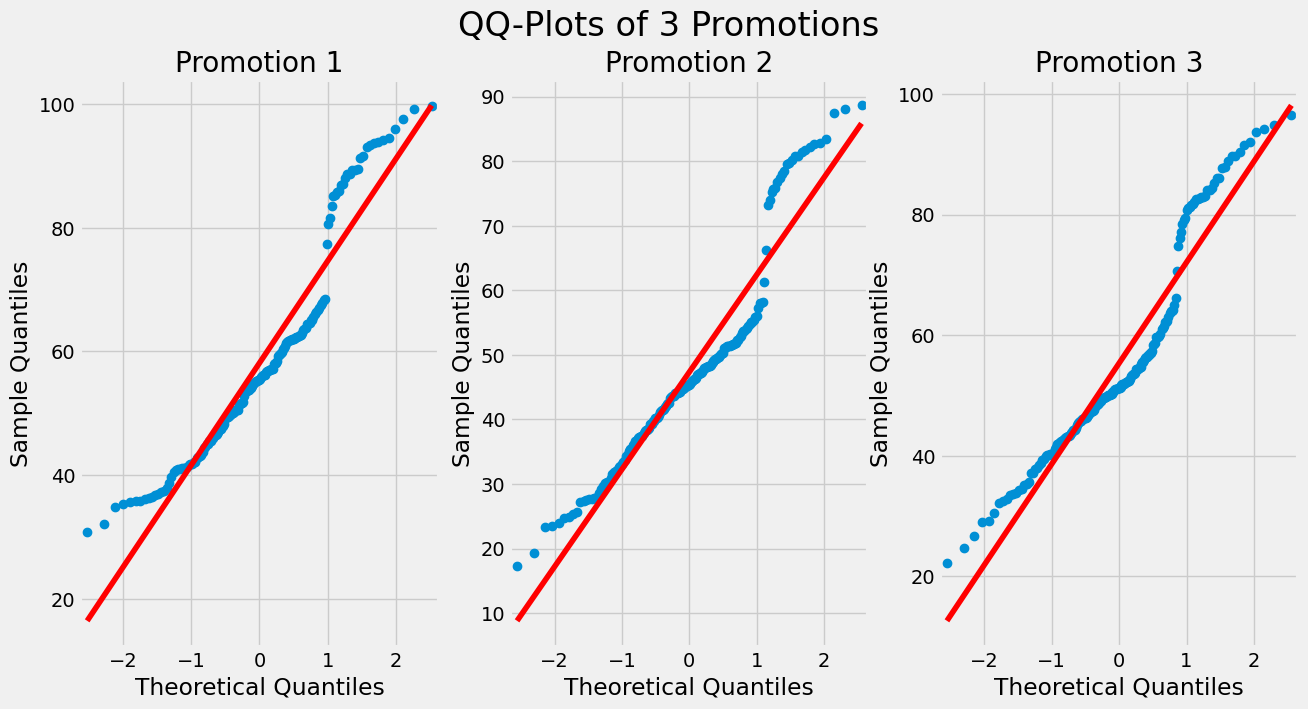

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 7))
sm.qqplot(promotion_1_sales, line='s', ax=ax[0])
sm.qqplot(promotion_2_sales, line='s', ax=ax[1])
sm.qqplot(promotion_3_sales, line='s', ax=ax[2])

fig.suptitle('QQ-Plots of 3 Promotions', fontsize='xx-large')
ax[0].set_title('Promotion 1')
ax[1].set_title('Promotion 2')
ax[2].set_title('Promotion 3')
plt.show()

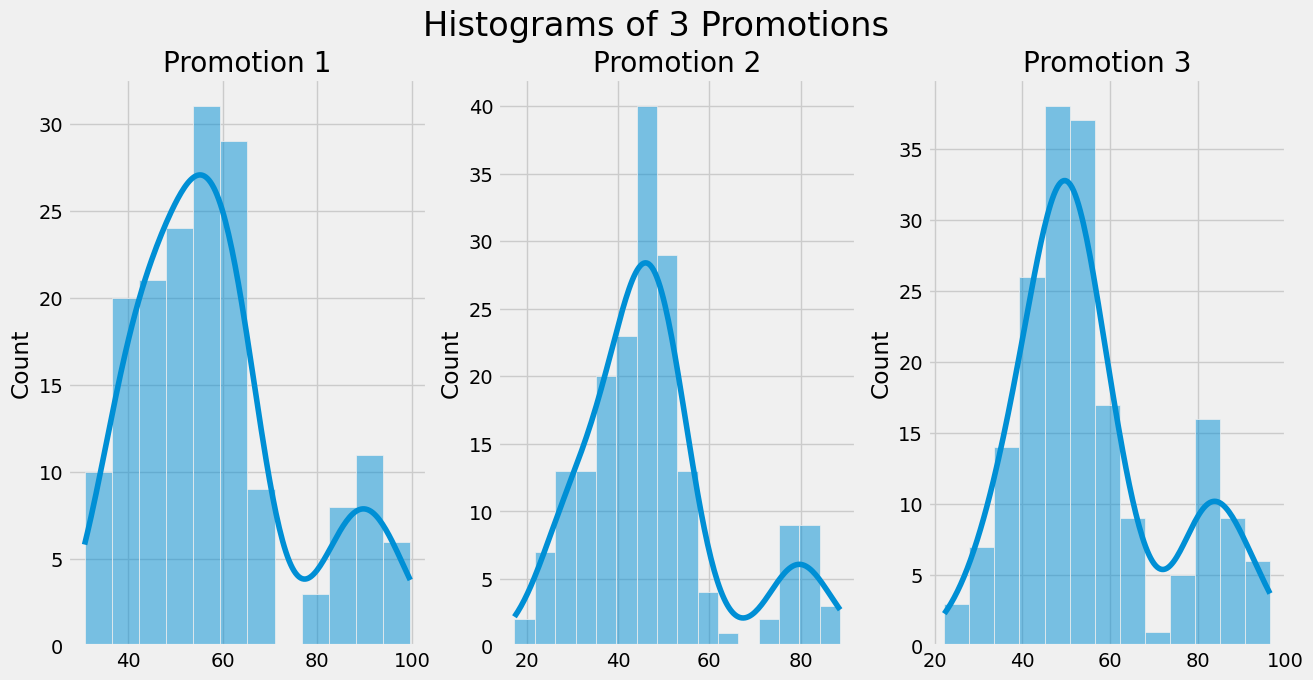

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 7))
sns.histplot(promotion_1_sales, kde=True, ax=ax[0])
sns.histplot(promotion_2_sales, kde=True, ax=ax[1])
sns.histplot(promotion_3_sales, kde=True, ax=ax[2])

fig.suptitle('Histograms of 3 Promotions', fontsize='xx-large')
ax[0].set_title('Promotion 1')
ax[1].set_title('Promotion 2')
ax[2].set_title('Promotion 3')
plt.show()

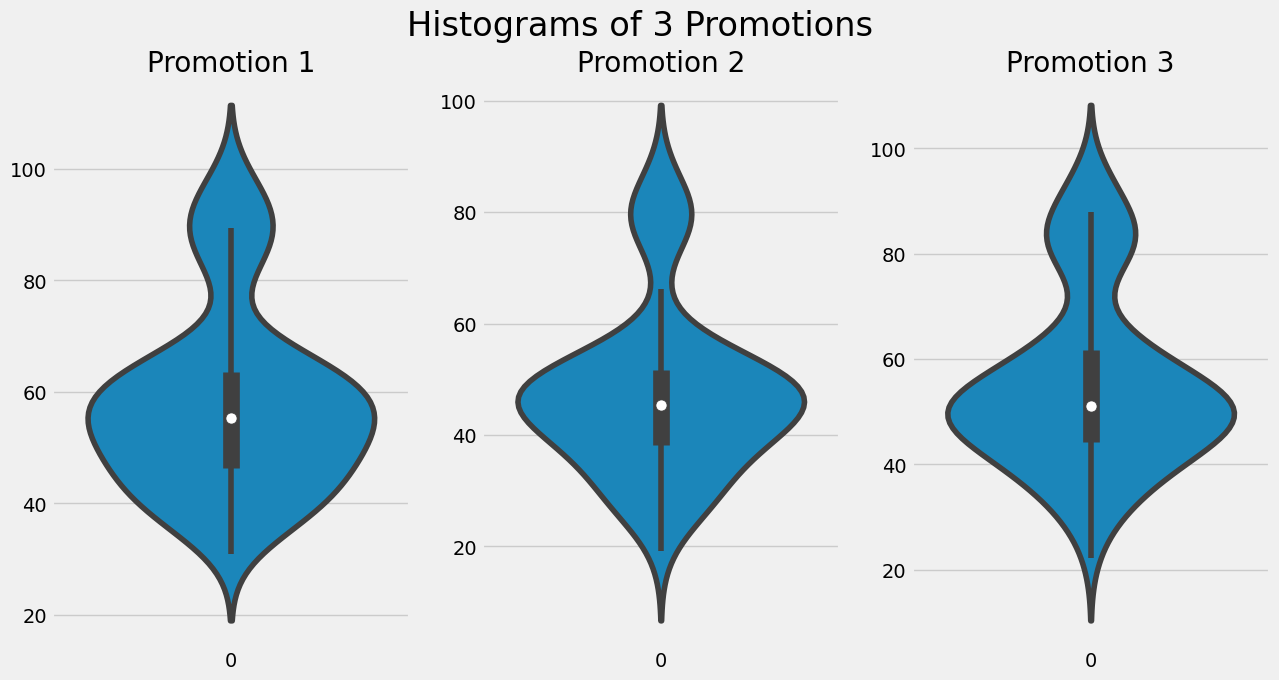

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 7))
sns.violinplot(promotion_1_sales, kde=True, ax=ax[0])
sns.violinplot(promotion_2_sales, kde=True, ax=ax[1])
sns.violinplot(promotion_3_sales, kde=True, ax=ax[2])

fig.suptitle('Histograms of 3 Promotions', fontsize='xx-large')
ax[0].set_title('Promotion 1')
ax[1].set_title('Promotion 2')
ax[2].set_title('Promotion 3')
plt.show()

From the histograms and violin plots, we can see that the sales of each promotions are a bit right-skewed. To assess the normality further, perform normality test.

**Test used: Shapiro-Wilk's Test**

- H0: The data is close to normal distribution.
- H1: The data is not close to normal distribution.

Significance level: 0.05

In [11]:
stat, p_value = shapiro(promotion_1_sales)
print(f'P-value of Promotion 1 Shapiro Wilk test: {p_value}')

stat, p_value = shapiro(promotion_2_sales)
print(f'P-value of Promotion 2 Shapiro Wilk test: {p_value}')

stat, p_value = shapiro(promotion_3_sales)
print(f'P-value of Promotion 3 Shapiro Wilk test: {p_value}')

P-value of Promotion 1 Shapiro Wilk test: 1.9772498305314912e-08
P-value of Promotion 2 Shapiro Wilk test: 5.456247009760773e-09
P-value of Promotion 3 Shapiro Wilk test: 1.499518376135711e-08


### Check for Variance Homogeneity

**Test used: Levene's Test**

- H0: There is no difference between variance of each group.
- H1: There is a difference between variance of each group.

Significance level: 0.05

In [12]:
stat, p_value = levene(promotion_1_sales, promotion_2_sales, promotion_3_sales)
p_value

0.2817514565692118

The p-value > 0.05, thus we fail to reject H0, so the sales variance between each promotion type are not statistically different from one another (variance homogeneity assumption is met).

### Kruskal-Wallis One-Way ANOVA

Despite the sales variance of 3 promotion types are equal, the sales distribution for each promotion is not really normally distributed. Since the ANOVA assumptions are not fully met, I use a non-parametric test, Kruskal-Wallis test, to determine how promotion affects the sales.

H0: There is no significant difference of sales rank sums between each promotion type.

H1: There is a significant difference of sales rank sums between each promotion type.

Significance Level: 0.05

> Using the Kruskal-Wallis test, instead of questioning "**is there a difference in mean?**", we question "**is there a difference in the rank totals?**". Kruskal-Wallis test works by assigning a rank to each of the observation (row), and compare the rank sums in all 3 promotion types. This process does not require the mean, hence the sales in each promotion does not have to satisfy the normal distribution (or any other distribution).

In [13]:
print('Number of samples in each group (promotion type):')
print(f'Promotion Type 1: {len(promotion_1_sales)}')
print(f'Promotion Type 2: {len(promotion_2_sales)}')
print(f'Promotion Type 3: {len(promotion_3_sales)}')
print(f'Total observations: {len(df)}')

Number of samples in each group (promotion type):
Promotion Type 1: 172
Promotion Type 2: 188
Promotion Type 3: 188
Total observations: 548


In [14]:
all_promotions_df = df[['Promotion', 'SalesInThousands']].sort_values('SalesInThousands')
all_promotions_df['Rank'] = np.arange(1, len(all_promotions_df) + 1, 1)
all_promotions_df.head()

,Promotion,SalesInThousands,Rank
285,2,17.34,1
283,2,19.26,2
21,3,22.18,3
19,2,23.35,4
287,2,23.44,5


In [15]:
promotion_1_df = all_promotions_df[all_promotions_df['Promotion'] == 1]
promotion_2_df = all_promotions_df[all_promotions_df['Promotion'] == 2]
promotion_3_df = all_promotions_df[all_promotions_df['Promotion'] == 3]

promotion_1_df.head(3)

,Promotion,SalesInThousands,Rank
307,1,30.81,29
294,1,32.05,34
11,1,34.75,51


In [16]:
rank_sums_df = all_promotions_df.groupby('Promotion').agg({'Rank': 'sum'})
rank_sums_df

,Rank
Promotion,
1,56081
2,39236
3,55109


In [17]:
promotion_1_mean_rank_sum = rank_sums_df['Rank'].iloc[0] / len(promotion_1_df)
promotion_2_mean_rank_sum = rank_sums_df['Rank'].iloc[1] / len(promotion_2_df)
promotion_3_mean_rank_sum = rank_sums_df['Rank'].iloc[2] / len(promotion_3_df)

print(f"Sales mean rank sum if using promotion type 1: {promotion_1_mean_rank_sum}")
print(f"Sales mean rank sum if using promotion type 2: {promotion_2_mean_rank_sum}")
print(f"Sales mean rank sum if using promotion type 3: {promotion_3_mean_rank_sum}")

Sales mean rank sum if using promotion type 1: 326.05232558139534
Sales mean rank sum if using promotion type 2: 208.70212765957447
Sales mean rank sum if using promotion type 3: 293.1329787234043


Are these 3 mean rank sums significantly different?

In [18]:
n = len(all_promotions_df)
E = (n + 1) / 2
variance = ((n ** 2) - 1) / n
print(f'The expected value of sales rank sums if there is no difference between groups: ${E}k')

The expected value of sales rank sums if there is no difference between groups: $274.5k


H statistic formula.

$$ H = \frac{n - 1}{n} * \sum_{i=1}^{k} \frac{n_i * (R - E)^2}{\sigma^2}  $$

Where:

- $ n $ is the number of all observations (cases).
- $ k $ is the number of groups in the independent variable.
- $ R $ is the mean of rank sums of every group in the independent variable.
- $ E $ is the expected value of rank sums of dependent variable.
- $ \sigma^2 $ is the variance of rank sums of dependent variable.

In this case independent variable: Promotion type, dependent variable: Sales in thousands.

In [19]:
stat, p_value = kruskal(promotion_1_sales, promotion_2_sales, promotion_3_sales)
print(f'Kruskal-Wallis H statistic: {stat}')
print(f'p-value: {p_value}')

Kruskal-Wallis H statistic: 53.29475169322799
p-value: 2.6741866266697816e-12


p-value < 0.05, reject H0, hence we can conclude that there is a statistical difference of sales rank total (in thousands) between each group of promotion. But we still don't know which promotion type differs from which one. So, we can perform Tukey's Multiple Comparison test.

### Tukey's HSD Test

Tukey's honestly significance test (HSD) is a multiple comparison test that is also a post-hoc test for ANOVA. It works by comparing the means of one group with any other group. However, since the variance of each group are the same, but the sample size of each group are not equal, the Tukey-Kramer test is a better option rather than Tukey HSD test.

In [20]:
multiple_comparison = MultiComparison(df['SalesInThousands'], df['Promotion'])
tukeyhsd = multiple_comparison.tukeyhsd(alpha=0.05)
tukeyhsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-10.7696,0.0,-14.7738,-6.7654,True
1,3,-2.7345,0.2444,-6.7388,1.2697,False
2,3,8.0351,0.0,4.1208,11.9493,True


From the result above, we can conclude that:
- Promotion type 1 is significantly different from promotion type 2.
- Promotion type 1 is not significantly different from promotion type 3.
- Promotion type 2 is significantly different from promotion type 3.